In [86]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import os, tqdm
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

Let us first read the train and test files

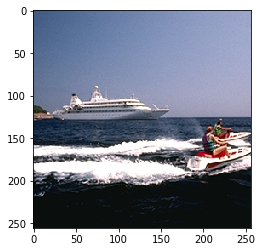

In [87]:
img = cv2.imread(r'./MIT_split/train/coast/arnat59.jpg')[:,:,::-1]
plt.imshow(img)

In [90]:
def accuracy(predictions, labels):
    return sum(predictions == labels) / len(labels)

def precision(predictions, labels, class_label):
    tp = np.sum((predictions == class_label) & (labels == class_label))
    fp = np.sum((predictions == class_label) & (labels != class_label))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall(predictions, labels, class_label):
    tp = np.sum((predictions == class_label) & (labels == class_label))
    fn = np.sum((predictions != class_label) & (labels == class_label))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def average_precision(predictions, labels):
    classes = np.unique(labels)
    return np.mean([precision(predictions, labels, c) for c in classes])

def average_recall(predictions, labels):
    classes = np.unique(labels)
    return np.mean([recall(predictions, labels, c) for c in classes])

def average_f1(predictions, labels):
    return 2 * average_precision(predictions, labels) * average_recall(predictions, labels) / (average_precision(predictions, labels) + average_recall(predictions, labels))

class BoVW():
    def __init__(self, config, size_per_class=1e9, preload_features=False, folder_path_train='./MIT_split/train', folder_path_test='./MIT_split/test'):

        self.config = config
        self.train_dataset = {'image_paths': [], 'labels': []}
        self.test_dataset = {'image_paths': [], 'labels': []}

        for label in os.listdir(folder_path_train):
            for i,image_name in enumerate(os.listdir(os.path.join(folder_path_train, label))):
                self.train_dataset['image_paths'].append(os.path.join(folder_path_train, label, image_name))
                self.train_dataset['labels'].append(label)

                # good for making a small test
                if i >= size_per_class:
                    break
        
        self.train_dataset['labels'] = np.array(self.train_dataset['labels'])
        for label in os.listdir(folder_path_test):
            for i,image_name in enumerate(os.listdir(os.path.join(folder_path_test, label))):
                self.test_dataset['image_paths'].append(os.path.join(folder_path_test, label, image_name))
                self.test_dataset['labels'].append(label)
                
                # good for making a small test
                if i >= size_per_class:
                    break
        
        self.test_dataset['labels'] = np.array(self.test_dataset['labels'])
        self.train_features, self.test_features = self._compute_descriptors(preload=preload_features)

    def _compute_descriptors(self, preload=False):

        if preload:
            return ...
        
        # Initialize lists to store results
        features_train, features_test = [], []

        # Iterate over all files in the directory
        for i,dataset in enumerate([self.train_dataset['image_paths'], self.test_dataset['image_paths']]):
            for j,filename in enumerate(tqdm.tqdm(dataset, desc='Extracting features from dataset %d' % i)):
                # Load the imag
                img = cv2.imread(filename)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                if self.config['descriptor'] == 'dense_sift':
                    # Initialize Dense SIFT extractor
                    sift = cv2.SIFT_create()
                    kp = [cv2.KeyPoint(x, y, self.config['step_size']) for y in range(0, gray.shape[0], self.config['step_size'])
                                                                       for x in range(0, gray.shape[1], self.config['step_size'])]
                    kp, des = sift.compute(gray, kp)

                elif self.config['descriptor'] == 'sift':
                    # Initialize Dense SIFT extractor
                    sift = cv2.SIFT_create()
                    _, des = sift.detectAndCompute(gray, None)

                elif self.config['descriptor'] == 'akaze':
                    # Initialize AKAZE extractor
                    akaze = cv2.AKAZE_create()
                    _, des = akaze.detectAndCompute(gray, None)
                
                if i == 0:
                    features_train.append(des)
                else:
                    features_test.append(des)
        return np.array(features_train), np.array(features_test)
        

    def fit(self):
        self.kmeans = MiniBatchKMeans(n_clusters=self.config['n_words'], verbose=False, batch_size=1024, compute_labels=False, random_state=123)
        self.kmeans.fit(self.train_features.reshape(-1,128))

        visual_words = np.zeros((len(self.train_features), self.config['n_words']), dtype=int)
        for i in range(len(self.train_features)):
            words = self.kmeans.predict(self.train_features[i])
            visual_words[i,:] = np.bincount(words, minlength=self.config['n_words'])
            
        
        #Dimensionality reduction
        if self.config['dimentionality_reduction'] is not None:
            if self.config['dimentionality_reduction'] == 'pca':
                self.dim_red = PCA(n_components = self.config['n_components'])
            if self.config['dimentionality_reduction'] == 'lda':
                self.dim_red = LinearDiscriminantAnalysis(n_components = self.config['n_components'])

            visual_words = self.dim_red.fit_transform(visual_words, self.train_dataset['labels'])
        
        # Classification
        if self.config['classifier'] == 'knn':
            self.classifier = KNeighborsClassifier(n_neighbors=self.config['n_neigh'], n_jobs=-1, metric=self.config['metric'])
        elif self.config['classifier'] == 'svm':
            self.classifier = SVC(kernel = self.config['kernel'], gamma = 'auto')
        elif self.config['classifier'] == 'logistic':
            self.classifier = LogisticRegression(multi_class = 'auto', penalty='l2', solver='lbfgs', max_iter = 200)
            
        self.classifier.fit(visual_words, self.train_dataset['labels'])

   
    def fit_cross_validation(self):
        
        kf = KFold(n_splits=self.config['n_folds'], shuffle=True, random_state=123)
        accuracies, recalls, precisions, f1s = [], [], [], []

        dim_red = None
        if self.config['dimentionality_reduction'] == 'pca':
            dim_red = PCA(n_components = self.config['n_components'])
        if self.config['dimentionality_reduction'] == 'lda':
            dim_red = LinearDiscriminantAnalysis(n_components = self.config['n_components'])

        for train_index, test_index in tqdm.tqdm(kf.split(self.train_features), desc='Cross validation', total=self.config['n_folds']):
            # Split features and labels for this fold
            X_train, X_test = self.train_features[train_index], self.train_features[test_index]
            y_train, y_test = self.train_dataset['labels'][train_index], self.train_dataset['labels'][test_index]

            # Fit KMeans and KNN
            kmeans_cv = MiniBatchKMeans(n_clusters=self.config['n_words'], verbose=False, batch_size=1024, compute_labels=False, random_state=123)
            kmeans_cv.fit(X_train.reshape(-1,128))

            visual_words = np.zeros((len(X_train), self.config['n_words']), dtype=int)
            for i in range(len(X_train)):
                words = kmeans_cv.predict(X_train[i])
                visual_words[i,:] = np.bincount(words, minlength=self.config['n_words'])
            
            # Dimensionality reduction
            if dim_red is not None:
                visual_words = dim_red.fit_transform(visual_words, y_train)

            # Classification
            if self.config['classifier'] == 'knn':
                classifier = KNeighborsClassifier(n_neighbors=self.config['n_neigh'], n_jobs=-1, metric=self.config['metric'])
            elif self.config['classifier'] == 'svm':
                classifier = SVC(kernel = self.config['kernel'], gamma = 'auto')
            elif self.config['classifier'] == 'logistic':
                classifier = LogisticRegression(multi_class = 'auto', penalty='l2',solver='lbfgs', max_iter = 200)
                
            classifier.fit(visual_words, y_train)
            
            # Predict
            visual_words_test = np.zeros((len(X_test), self.config['n_words']), dtype=int)

            for i in range(len(X_test)):
                words = kmeans_cv.predict(X_test[i])
                visual_words_test[i,:] = np.bincount(words, minlength=self.config['n_words'])
                
            if dim_red is not None:
                visual_words_test = dim_red.transform(visual_words_test)
                
            predictions = classifier.predict(visual_words_test)
            
            # Calculate metrics
            accuracies.append(accuracy(predictions, y_test))
            recalls.append(average_recall(predictions, y_test))
            precisions.append(average_precision(predictions, y_test))
            f1s.append(average_f1(predictions, y_test))

        return accuracies, recalls, precisions, f1s

    def predict(self):
        visual_words_test = np.zeros((len(self.test_features), self.config['n_words']), dtype=int)

        for i in range(len(self.test_features)):
            words = self.kmeans.predict(self.test_features[i])
            visual_words_test[i,:] = np.bincount(words, minlength=self.config['n_words'])
        
        if self.config['dimentionality_reduction'] is not None:
            visual_words_test = self.dim_red.transform(visual_words_test)
            
        return self.classifier.predict(visual_words_test)

config = {
    'descriptor': 'dense_sift',
    'step_size': 25,
    'n_words': 128,
    'n_neigh': 5,
    'metric': 'euclidean',
    'n_folds': 5,
    'dimentionality_reduction': 'pca',
    'n_components': 50,
    'level_pyramid': 1,
    'kernel': 'rbf',
    'classifier': 'logistic',
    'fisher_vector': False
}
bovw = BoVW(config, size_per_class=50)
bovw.fit()
predictions = bovw.predict()
#bovw.fit_cross_validation()


# del logistic, he posat l2 penalty, no se si seria ja massa feina provar amb l1 tmb


# falta implentar las divisiones de la piramide
# falta implementar el fisher vector
# falta implementar wandb
# norm/scaler????



Extracting features from dataset 0:   0%|          | 0/408 [00:00<?, ?it/s]

Extracting features from dataset 0:   0%|          | 2/408 [00:00<00:27, 14.58it/s]

Extracting features from dataset 0:   1%|          | 4/408 [00:00<00:27, 14.60it/s]

Extracting features from dataset 0:   1%|▏         | 6/408 [00:00<00:27, 14.89it/s]

Extracting features from dataset 0:   2%|▏         | 8/408 [00:00<00:27, 14.69it/s]

Extracting features from dataset 0:   2%|▏         | 10/408 [00:00<00:25, 15.57it/s]

Extracting features from dataset 0:   3%|▎         | 12/408 [00:00<00:24, 15.85it/s]

Extracting features from dataset 0:   3%|▎         | 14/408 [00:00<00:24, 16.12it/s]

Extracting features from dataset 0:   4%|▍         | 16/408 [00:01<00:23, 16.79it/s]

Extracting features from dataset 0:   4%|▍         | 18/408 [00:01<00:23, 16.94it/s]

Extracting features from dataset 0:   5%|▍         | 20/408 [00:01<00:24, 16.11it/s]

Extracting features from dataset 0:   5%|▌         | 22/408 [00:0

Extracting features from dataset 0:  43%|████▎     | 177/408 [00:11<00:15, 14.98it/s]

Extracting features from dataset 0:  44%|████▍     | 179/408 [00:11<00:14, 15.65it/s]

Extracting features from dataset 0:  44%|████▍     | 181/408 [00:11<00:14, 15.97it/s]

Extracting features from dataset 0:  45%|████▍     | 183/408 [00:11<00:14, 15.81it/s]

Extracting features from dataset 0:  45%|████▌     | 185/408 [00:11<00:14, 15.45it/s]

Extracting features from dataset 0:  46%|████▌     | 187/408 [00:11<00:14, 15.02it/s]

Extracting features from dataset 0:  46%|████▋     | 189/408 [00:11<00:14, 15.02it/s]

Extracting features from dataset 0:  47%|████▋     | 191/408 [00:12<00:14, 15.34it/s]

Extracting features from dataset 0:  47%|████▋     | 193/408 [00:12<00:13, 15.90it/s]

Extracting features from dataset 0:  48%|████▊     | 195/408 [00:12<00:13, 15.61it/s]

Extracting features from dataset 0:  48%|████▊     | 197/408 [00:12<00:13, 16.20it/s]

Extracting features from dataset 0:  49%|██

Extracting features from dataset 0:  87%|████████▋ | 353/408 [00:22<00:03, 16.51it/s]

Extracting features from dataset 0:  87%|████████▋ | 355/408 [00:22<00:03, 16.79it/s]

Extracting features from dataset 0:  88%|████████▊ | 357/408 [00:22<00:02, 17.32it/s]

Extracting features from dataset 0:  88%|████████▊ | 359/408 [00:22<00:02, 18.04it/s]

Extracting features from dataset 0:  88%|████████▊ | 361/408 [00:22<00:02, 17.85it/s]

Extracting features from dataset 0:  89%|████████▉ | 363/408 [00:22<00:02, 17.07it/s]

Extracting features from dataset 0:  89%|████████▉ | 365/408 [00:22<00:02, 16.46it/s]

Extracting features from dataset 0:  90%|████████▉ | 367/408 [00:22<00:02, 16.71it/s]

Extracting features from dataset 0:  90%|█████████ | 369/408 [00:22<00:02, 17.12it/s]

Extracting features from dataset 0:  91%|█████████ | 371/408 [00:23<00:02, 17.68it/s]

Extracting features from dataset 0:  91%|█████████▏| 373/408 [00:23<00:02, 17.31it/s]

Extracting features from dataset 0:  92%|██

Extracting features from dataset 1:  29%|██▉       | 119/408 [00:07<00:18, 15.52it/s]

Extracting features from dataset 1:  30%|██▉       | 121/408 [00:07<00:18, 15.66it/s]

Extracting features from dataset 1:  30%|███       | 123/408 [00:07<00:18, 15.68it/s]

Extracting features from dataset 1:  31%|███       | 125/408 [00:08<00:17, 16.10it/s]

Extracting features from dataset 1:  31%|███       | 127/408 [00:08<00:17, 16.15it/s]

Extracting features from dataset 1:  32%|███▏      | 129/408 [00:08<00:16, 16.83it/s]

Extracting features from dataset 1:  32%|███▏      | 131/408 [00:08<00:16, 16.39it/s]

Extracting features from dataset 1:  33%|███▎      | 134/408 [00:08<00:15, 17.70it/s]

Extracting features from dataset 1:  33%|███▎      | 136/408 [00:08<00:15, 17.83it/s]

Extracting features from dataset 1:  34%|███▍      | 138/408 [00:08<00:15, 17.97it/s]

Extracting features from dataset 1:  35%|███▍      | 141/408 [00:08<00:13, 19.10it/s]

Extracting features from dataset 1:  35%|██

Extracting features from dataset 1:  73%|███████▎  | 299/408 [00:18<00:06, 17.29it/s]

Extracting features from dataset 1:  74%|███████▍  | 301/408 [00:19<00:06, 17.07it/s]

Extracting features from dataset 1:  74%|███████▍  | 303/408 [00:19<00:06, 17.20it/s]

Extracting features from dataset 1:  75%|███████▌  | 306/408 [00:19<00:05, 18.26it/s]

Extracting features from dataset 1:  75%|███████▌  | 308/408 [00:19<00:05, 17.86it/s]

Extracting features from dataset 1:  76%|███████▌  | 310/408 [00:19<00:05, 17.65it/s]

Extracting features from dataset 1:  76%|███████▋  | 312/408 [00:19<00:05, 17.20it/s]

Extracting features from dataset 1:  77%|███████▋  | 314/408 [00:19<00:05, 17.08it/s]

Extracting features from dataset 1:  77%|███████▋  | 316/408 [00:19<00:05, 17.43it/s]

Extracting features from dataset 1:  78%|███████▊  | 318/408 [00:19<00:05, 17.64it/s]

Extracting features from dataset 1:  78%|███████▊  | 320/408 [00:20<00:04, 18.08it/s]

Extracting features from dataset 1:  79%|██

In [91]:
print('Accuracy: %.2f' % accuracy(predictions, bovw.test_dataset['labels']))
print('Recall: %.2f' % average_recall(predictions, bovw.test_dataset['labels']))
print('Precision: %.2f' % average_precision(predictions, bovw.test_dataset['labels']))
print('F1: %.2f' % average_f1(predictions, bovw.test_dataset['labels']))

Accuracy: 0.71
Recall: 0.71
Precision: 0.71
F1: 0.71


In [81]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_images_filenames = [n[26:] for n in train_images_filenames]
test_images_filenames  = [n[26:] for n in test_images_filenames]
train_labels = pickle.load(open('train_labels.dat','rb')) 
test_labels = pickle.load(open('test_labels.dat','rb'))

We create a KAZE/SIFT/.... object detector and descriptor

In [23]:
Detector = cv2.KAZE_create(threshold=0.0001)

We compute the  descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [24]:
Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=Detector.detectAndCompute(gray,None)
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

We now compute a k-means clustering on the descriptor space

In [25]:
k = 128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=2560, compute_labels=False, n_clusters=128,
                random_state=42, reassignment_ratio=0.0001, verbose=False)

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [26]:
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

We build a k-nn classifier and train it with the train descriptors

In [27]:
knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knn.fit(visual_words, train_labels) 

KNeighborsClassifier(metric='euclidean', n_jobs=-1)

We end up computing the test descriptors and compute the accuracy of the model

In [28]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=Detector.detectAndCompute(gray,None)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

In [29]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)

59.23172242874845


Dimensionality reduction, with PCA and LDA

In [30]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnpca.fit(VWpca, train_labels) 
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print(accuracy)

58.48822800495663


In [71]:
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda = lda.fit_transform(visual_words,train_labels)
knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnlda.fit(VWlda, train_labels) 
vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print(accuracy)

NameError: name 'visual_words' is not defined